In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, std
from sklearn.model_selection import KFold
import operator
import pickle
from joblib import dump, load

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,precision_score,roc_auc_score,recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from scipy.sparse import csr_matrix, hstack


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle, resample


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('precision', 2)

# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from textblob import TextBlob, Word
# # nltk.download('stopwords')
# # nltk.download('punkt')

# stopwords = stopwords.words('english')
# from nltk.stem import WordNetLemmatizer

### Pre-processing functions

### Removing punctuation 

In [388]:
def punc_reomval(x):
    
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in x:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

In [389]:
def preprocessing(x):
  
    x = re.sub(r'\W', ' ', str(x))
    x = re.sub(r'\s+[a-zA-Z]\s+', ' ', x)
    x = re.sub(r'\^[a-zA-Z]\s+', ' ', x) 
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    return x

### Adding Feature

In [390]:
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

### Training the model with training dataset

In [391]:
# Import Dataset
data = pd.read_excel(r'G:\Users\C888653\Reclassification_Algorithm\Trainning dataset.xlsx')


In [392]:
data.shape

(845, 11)

In [393]:
data[:3]

,po_key,package,Reassigned package,Reassigned subpackage,subpackage,po_total_amount_ordered_in_usd_currency,purchase_order_description,material_group_description,vendor_name,gpo categories,description
0,450484654500010,Non ZBB,Technology,Application Support,Non ZBB Accounts,54733.60,HBSIS Mobile App,APPLICATION SUPPORT SERVICES,HBSIS Soluções em TI Ltda,TECHNOLOGY,Other Technology
1,450476061500010,Non ZBB,Technology,Application Support,Non ZBB Accounts,27042.00,Profisee Subscription renewal,PROJECT SERVICES,Profisee Group Inc,TECHNOLOGY,Applications Saas
2,450480205400010,Non ZBB,Technology,Application Support,Non ZBB Accounts,49006.83,Zanders IT2 Bottomline Decommission,PROJECT SERVICES,Zanders,TECHNOLOGY,Application Licenses Maintenance


In [394]:
data["purchase_order_description"]=data["purchase_order_description"].apply(lambda x: punc_reomval(x))
data["purchase_order_description"]=data["purchase_order_description"].apply(lambda x: preprocessing(x))

In [395]:
training_data=data[["purchase_order_description", "Reassigned subpackage"]]

In [396]:
training_data["Reassigned subpackage"]=training_data["Reassigned subpackage"].replace(to_replace="Telecom", value="Telecom Services")

In [397]:
def le(y):
    le=LabelEncoder()
    from collections import Counter
    Labelling=le.fit_transform(y)
    Labelling_inverse=le.inverse_transform(Labelling)
    dic=dict(zip(Counter(Labelling_inverse),Counter(Labelling)))
#     print(dic)
            
    return(pd.Series(Labelling), dic)

In [398]:
yT, dic=le(training_data["Reassigned subpackage"])

In [399]:
training_data["le_y"]=yT

In [400]:
X=training_data["purchase_order_description"].values
y=training_data["le_y"].values

### reshuffling and dividing the dataset into :
    train test validate

In [402]:
def ttv(training_data  ,train_percent=.6, validate_percent=.2,seed=np.random.seed(0) ):
    m=len(training_data.index)
    perm = np.random.permutation(training_data.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = training_data.iloc[perm[:train_end]]
    validate = training_data.iloc[perm[train_end:validate_end]]
    test = training_data.iloc[perm[validate_end:]]
    return(train, validate, test)

In [407]:
def tt(training_data  ,train_percent=.8, test_percent=.2,seed=np.random.seed(1) ):
    m=len(training_data.index)
    perm = np.random.permutation(training_data.index)
    train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
    train = training_data.iloc[perm[:train_end]]
#     validate = training_data.iloc[perm[train_end:validate_end]]
    test = training_data.iloc[perm[train_end:]]
    return(train,test)

In [411]:
train, test= tt(training_data, 0.85,0.15)

In [412]:
train["Reassigned subpackage"].value_counts()

Application Support     362
Workplace               134
Datacenter               90
Digital Security         64
Application Licenses     33
Telecom Services         22
Mobile Services          13
Name: Reassigned subpackage, dtype: int64

In [413]:
# validate["Reassigned subpackage"].value_counts()

In [414]:
test["Reassigned subpackage"].value_counts()

Application Support     62
Workplace               25
Datacenter              21
Digital Security        10
Application Licenses     5
Telecom Services         4
Name: Reassigned subpackage, dtype: int64

#### Tfidf

In [464]:
def tfidfFit(docs, new_docs=None):
    cv=CountVectorizer()
    word_count_vector=cv.fit_transform(docs)
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
#     df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names())
#     df_idf.sort_values(by=['idf_weights'])
    count_vector=cv.transform(new_docs)
    tf_idf_vector=tfidf_transformer.transform(count_vector)
    feature_names = cv.get_feature_names()
    df = pd.DataFrame(tf_idf_vector.T.todense(), index=feature_names)
#     df.sort_values(by=["tfidf"],ascending=False)
    vocab=cv.vocabulary_
    return(vocab,df)
 
 
    

#     vect= TfidfVectorizer(stop_words=None, ngram_range=(1,3)).fit(X)
#     return vect

In [417]:
def vectors(X,X_train, X_test):
    vect= TfidfVectorizer(stop_words=None, ngram_range=(1,3)).fit(X)
    print('Vocabulary len:', len(vect.get_feature_names()))
    print('Longest word:', max(vect.vocabulary_, key=len))
    vocab=vect.vocabulary_
    features=vect.get_feature_names()

    X_train_vectorized = vect.transform(X_train)
    X_train_vectorized = add_feature(X_train_vectorized, pd.Series(X_train).str.len())

    X_test_vectorized = vect.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, pd.Series(X_test).str.len())


    return X_train_vectorized , X_test_vectorized,vocab, features, vect



In [431]:
X_train=train["purchase_order_description"].values
# X_valid=validate["purchase_order_description"].values
X_test=test["purchase_order_description"].values
y_train=train["Reassigned subpackage"]
# y_valid=validate["Reassigned subpackage"]
y_test=test["Reassigned subpackage"]

In [432]:
X_train_vectorized , X_test_vectorized, vocab, features, vector= vectors(X, X_train, X_test)


Vocabulary len: 3150
Longest word: crq00chg0412379sap marketplace cleanup


In [433]:
features.append("doc_len")

In [434]:
# features
# d=pd.DataFrame(X_train_vectorized.todense())

In [435]:
vocab_dict={v:k  for k, v in vocab.items()}

In [436]:
vocab_dict[3150]="Doc_len"

In [437]:
dict(list(vocab_dict.items())[-3:])

{3148: 'zx office', 3149: 'zx office move', 3150: 'Doc_len'}

In [438]:
X_train_df=pd.DataFrame(X_train_vectorized.todense(), index=X_train, columns=list(vocab_dict.values()))
# X_valid_df=pd.DataFrame(X_valid_vectorized.todense(), index=X_valid, columns=list(vocab_dict.values()))
X_test_df=pd.DataFrame(X_test_vectorized.todense(), index=X_test, columns=list(vocab_dict.values()))

#### modelling

In [439]:
def modelling(model, X_train_vectorized ,y_train, X_test_vectorized, y_test, vect):
    
    model.fit(X_train_vectorized, y_train)

    y_pred = model.predict(X_test_vectorized)
    print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))


    index = np.array(vect.get_feature_names() + ['length_of_doc'])# adding name of column (last)
    try:
        values  = model.coef_[0]
        features_series = pd.Series(data=values,index=index)
        print(features_series.head(3))

        print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
        print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))
    except: 
        print("model has no coefficients")

    return y_pred


In [440]:
# from sklearn.ensemble import RandomForestClassifier
# model=RandomForestClassifier(random_state=80)
# y_pred=modelling(model, X_train_df ,y_train, X_valid_df, y_valid, vector)


In [441]:
# from sklearn.ensemble import RandomForestClassifier
# model2=RandomForestClassifier(random_state=82)
# y_pred2=modelling(model2,  X_train_vectorized ,y_train, X_valid_vectorized, y_valid, vector)

In [442]:
# from sklearn.tree import ExtraTreeClassifier
# model3=ExtraTreeClassifier(random_state=84)
# y_pred3=modelling(model3,  X_train_vectorized ,y_train, X_valid_vectorized, y_valid, vector)

In [443]:
# from sklearn.tree import ExtraTreeClassifier
# model4=ExtraTreeClassifier(random_state=86)
# y_pred4=modelling(model4,  X_train_df ,y_train, X_valid_df, y_valid, vector)

#### Cross Validation

In [444]:
def cross_val(model, X_train_vectorized ,y_train):
    all_accuracies = cross_val_score(estimator=model, X=X_train_vectorized , y=y_train, cv=5)
    print("mean of accuracies : ", all_accuracies.mean())
    print("std of accuracies : " , all_accuracies.std())
    return all_accuracies

In [445]:
# cross_val(model, X_train_df,y_train)

In [446]:
# cross_val(model2, X_train_vectorized,y_train)

In [447]:
# cross_val(model3, X_train_df,y_train)

In [448]:
# cross_val(model4, X_train_vectorized,y_train)

#### Grid Search Cross Validatio

In [449]:
# grid_param = {
#     'n_estimators': [100, 300, 500, 800, 1000],
#     'criterion': ['gini', 'entropy'],
#     'bootstrap': [True, False],
#     'max_features': [50, 100, 500, 700, 1000],
#      }


In [450]:
# gd_sr = GridSearchCV(estimator=model,
#                      param_grid=grid_param,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=-1)

In [451]:
# gd_sr.fit(X_train_vectorized,y_train)

In [452]:
# best_parameters = gd_sr.best_params_
# print(best_parameters)
# best_result = gd_sr.best_score_
# print(best_result)


In [453]:
# param_grid = {
#     'clf__n_estimators': [100, 500],
#     'clf__criterion': ['gini', 'entropy'],
#     'clf__bootstrap': [True, False]
   
#      }


In [454]:
# grid = GridSearchCV(pipeline, cv=6, param_grid=param_grid)
# grid.fit(X_train,y_train)

In [455]:
# print("Best: %f using %s" % (grid.best_score_, 
#     grid.best_params_))
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# params = grid.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [456]:
model=RandomForestClassifier(random_state=80, criterion="entropy",n_estimators=1000)

In [457]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=80,
            verbose=0, warm_start=False)

In [458]:
M=model.fit(X_train_df, y_train)

In [459]:
M.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [460]:
len(M.feature_importances_)

3151

In [461]:
important_features = pd.Series(data=M.feature_importances_,index=X_train_df.columns)
important_features.sort_values(ascending=False,inplace=True)

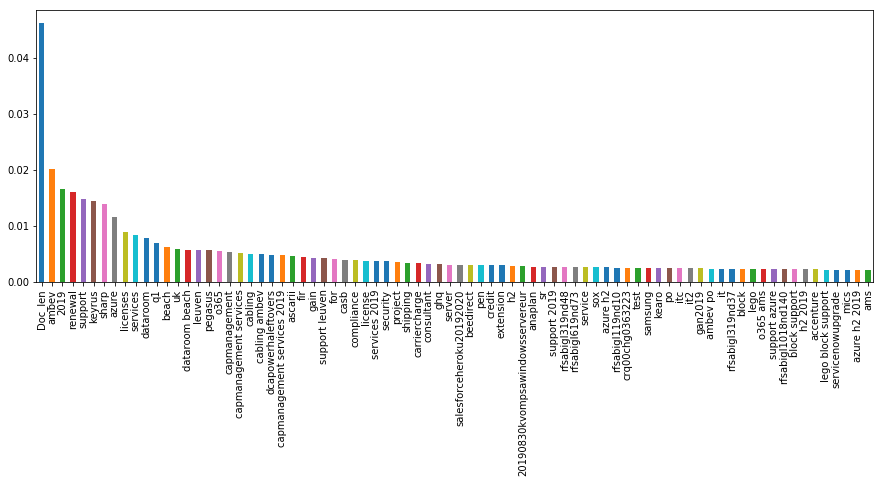

In [462]:
%matplotlib inline
plt.figure(figsize=(15, 5))
important_features[:80].plot(kind="bar", rot=90)

In [463]:
y_pred=modelling(model, X_train_df ,y_train, X_test_df, y_test,vector)

Accuracy: 71.65%
model has no coefficients


In [474]:
import joblib
#Save vectorizer.vocabulary_
joblib.dump(vector,r"G:\Reclassification_Algorithm\feature.joblib")
joblib.dump(model,r"G:\Reclassification_Algorithm\model.joblib")
joblib.dump(vocab_dict,r"G:\Reclassification_Algorithm\vocab.joblib")
# joblib.dump(vocab,open(r"G:\Reclassification_Algorithm\model.joblib","wb"))


['G:\\Users\\C888653\\Reclassification_Algorithm\\vocab.joblib']

Names of files: 

                feature.joblib--tfidf features
                model.joblib
                vocab_dict--dictionary 
    